In [1]:
import networkx as nx
from node2vec import Node2Vec
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.data import Data

/Users/yyp/opt/anaconda3/envs/general/lib/python3.8/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/yyp/opt/anaconda3/envs/general/lib/python3.8/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN2at27getStepCallbacksUnlessEmptyENS_11RecordScopeE
  Referenced from: <07E70809-2C28-3CDA-B2BD-1B237A2794F1> /Users/yyp/opt/anaconda3/envs/general/lib/python3.8/site-packages/libpyg.so
  Expected in:     <69BDC6DF-7542-3ECC-919E-18ED46F5C121> /Users/yyp/opt/anaconda3/envs/general/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


In [2]:
data_path = 'NCSU-DigIC-GraphData-2023-07-25/'

In [3]:
with gzip.open(data_path + 'xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

conn=np.load(data_path + 'xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

congestion_data = np.load(data_path + 'xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape = [instances.shape[0],])
capacity = np.zeros(shape = [instances.shape[0],])


def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst


for k in range(instances.shape[0]):
    # print(k)
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    c = 0
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
        c += congestion_data['capacity'][lyr][i][j]
    demand[k] = d
    capacity[k] = c
        
instances['routing_demand'] = demand
instances['routing_capacity'] = capacity
instances['congestion'] = demand - capacity

In [4]:
instances

,name,id,xloc,yloc,cell,orient,routing_demand,routing_capacity,congestion
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,28.0,-8.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,28.0,-5.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,33.0,-10.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,33.0,-11.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,23.0,-2.0
...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,31.0,0.0
3948,U4125,3948,33664,66048,42,0,30.0,30.0,0.0
3949,U4128,3949,23296,66048,34,0,27.0,29.0,-2.0
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,33.0,-5.0


In [5]:
with gzip.open(data_path + 'cells.json.gz','rb') as f:
    cells = json.loads(f.read().decode('utf-8'))

cells = pd.DataFrame(cells)
cells

,name,width,height,terms,id
0,AND2_X1,768,1536,"[{'name': 'A1', 'id': 1, 'dir': 0}, {'name': '...",0
1,AND2_X2,896,1536,"[{'name': 'A1', 'id': 1, 'dir': 0}, {'name': '...",1
2,AND3_X1,1024,1536,"[{'name': 'A1', 'id': 1, 'dir': 0}, {'name': '...",2
3,AND3_X2,1024,1536,"[{'name': 'A1', 'id': 1, 'dir': 0}, {'name': '...",3
4,AND4_X1,1152,1536,"[{'name': 'A1', 'id': 1, 'dir': 0}, {'name': '...",4
...,...,...,...,...,...
75,XOR2_X1,1152,1536,"[{'name': 'A1', 'id': 1, 'dir': 0}, {'name': '...",75
76,sram_84b_64_1rw_freepdk45,133952,199824,"[{'name': 'addr0[0]', 'id': 1, 'dir': 0}, {'na...",76
77,sram_128b_512_1rw_freepdk45,384744,259808,"[{'name': 'addr0[0]', 'id': 1, 'dir': 0}, {'na...",77
78,sram_88b_64_1rw_freepdk45,138920,201296,"[{'name': 'addr0[0]', 'id': 1, 'dir': 0}, {'na...",78


In [6]:
# merge width and height to instances
new_instances = pd.merge(instances, cells[['id', 'width', 'height']], left_on='cell', right_on='id', how='left')
new_instances

,name,id_x,xloc,yloc,cell,orient,routing_demand,routing_capacity,congestion,id_y,width,height
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,28.0,-8.0,23,2176,1536
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,28.0,-5.0,23,2176,1536
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,33.0,-10.0,23,2176,1536
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,33.0,-11.0,23,2176,1536
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,23.0,-2.0,23,2176,1536
...,...,...,...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,31.0,0.0,42,512,1536
3948,U4125,3948,33664,66048,42,0,30.0,30.0,0.0,42,512,1536
3949,U4128,3949,23296,66048,34,0,27.0,29.0,-2.0,34,384,1536
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,33.0,-5.0,11,640,1536


In [7]:
new_instances = new_instances[['xloc', 'yloc', 'congestion', 'width', 'height', 'orient']]
new_instances

,xloc,yloc,congestion,width,height,orient
0,41984,44544,-8.0,2176,1536,0
1,41984,47616,-5.0,2176,1536,6
2,44160,44544,-10.0,2176,1536,0
3,44160,47616,-11.0,2176,1536,0
4,46336,47616,-2.0,2176,1536,0
...,...,...,...,...,...,...
3947,21888,53760,0.0,512,1536,4
3948,33664,66048,0.0,512,1536,0
3949,23296,66048,-2.0,384,1536,0
3950,40576,44544,-5.0,640,1536,0


In [8]:
# normalize xloc, yloc, congestion, width, height
# use one hot encoding for orient
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
onehotencoder = OneHotEncoder()
orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()

scaler = MinMaxScaler()
new_instances = scaler.fit_transform(new_instances[['xloc', 'yloc', 'congestion', 'width', 'height']])
new_instances

array([[0.49617152, 0.5       , 0.69230769, 0.51851852, 0.        ],
       [0.49617152, 0.53571429, 0.76923077, 0.51851852, 0.        ],
       [0.52220521, 0.5       , 0.64102564, 0.51851852, 0.        ],
       ...,
       [0.27258806, 0.75      , 0.84615385, 0.        , 0.        ],
       [0.47932619, 0.5       , 0.76923077, 0.07407407, 0.        ],
       [0.55436447, 0.5       , 0.56410256, 0.07407407, 0.        ]])

In [12]:
y = new_instances[:,2]
y.shape

(3952,)

In [13]:
# remove congestion from new_instances
node_features = np.delete(new_instances, 2, 1)
node_features = np.concatenate((node_features, orient), axis=1)
node_features.shape

(3952, 8)

In [14]:
source_nodes, target_nodes = np.nonzero(A)
edge_index = np.vstack((source_nodes, target_nodes))
edge_index

array([[   0,    0,    0, ..., 3951, 3951, 3951],
       [3951, 3950,   11, ...,    1,    0, 3951]], dtype=int32)

In [15]:
edge_index = torch.tensor(edge_index, dtype=torch.long)
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

data = Data(x=x, edge_index=edge_index, y=y)

In [16]:
class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True, dropout=0.6):
        super(GATConv, self).__init__(node_dim=0, aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.dropout = dropout

        # Linear transformation matrices
        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        # Attention coefficients
        self.attention = Parameter(torch.Tensor(1, heads, 2 * out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.attention)

    def forward(self, x, edge_index):
        x = torch.mm(x, self.weight).view(-1, self.heads, self.out_channels)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, size=None)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients
        x = torch.cat([x_i, x_j], dim=-1)
        alpha = (x * self.attention).sum(dim=-1)
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i)

        # Sample dropout for attention coefficients
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
        if self.concat:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)
        return aggr_out

In [17]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [18]:
num_nodes = 3952  # Or set this to the number of nodes in your graph
train_size = int(num_nodes * 0.8)  # Let's say 80% for training
val_size = int(num_nodes * 0.1)  # 10% for validation

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Use the first 80% of randomly permuted indices for training
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True

# Next 10% for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[train_size:train_size+val_size]] = True

# Last 10% for testing
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[train_size+val_size:]] = True

# Assign masks to your data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=8, hidden_channels=8, out_channels=1, heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

loss_values = []

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


/var/folders/r4/95grkc4j28g3vf9dczg43ghr0000gn/T/ipykernel_77347/4200476789.py:11: UserWarning: Using a target size (torch.Size([3161])) that is different to the input size (torch.Size([3161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])


Epoch 1, Loss: 0.6651484966278076
Epoch 2, Loss: 0.43918362259864807
Epoch 3, Loss: 0.2511480450630188
Epoch 4, Loss: 0.15578658878803253
Epoch 5, Loss: 0.09473707526922226
Epoch 6, Loss: 0.08881404995918274
Epoch 7, Loss: 0.09352593868970871
Epoch 8, Loss: 0.12728717923164368
Epoch 9, Loss: 0.18187536299228668
Epoch 10, Loss: 0.19329053163528442
Epoch 11, Loss: 0.1898985505104065
Epoch 12, Loss: 0.15574027597904205
Epoch 13, Loss: 0.14641393721103668
Epoch 14, Loss: 0.14061467349529266
Epoch 15, Loss: 0.09795941412448883
Epoch 16, Loss: 0.08774034678936005
Epoch 17, Loss: 0.0790136381983757
Epoch 18, Loss: 0.07516687363386154
Epoch 19, Loss: 0.08196908980607986
Epoch 20, Loss: 0.08111141622066498
Epoch 21, Loss: 0.0886889174580574
Epoch 22, Loss: 0.08824647217988968
Epoch 23, Loss: 0.1008143424987793
Epoch 24, Loss: 0.09216005355119705
Epoch 25, Loss: 0.09273328632116318
Epoch 26, Loss: 0.09102673828601837
Epoch 27, Loss: 0.08631102740764618
Epoch 28, Loss: 0.0826866403222084
Epoch 29

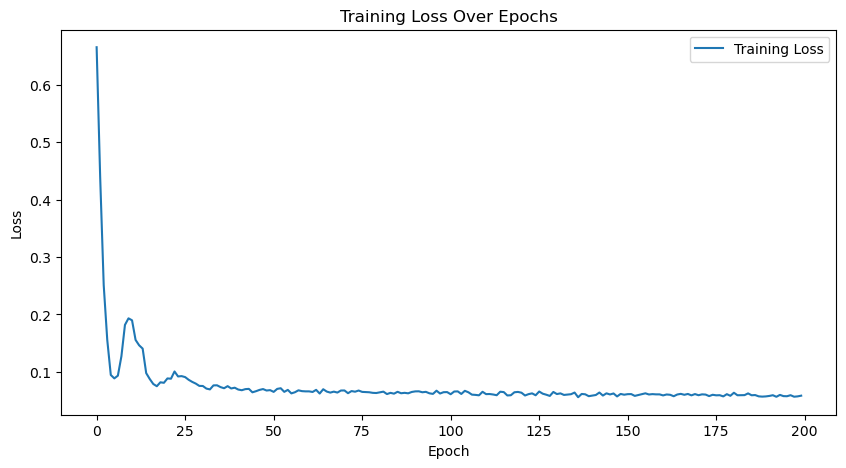

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [21]:
# Evaluate the model
model.eval()
out = model(data)
loss = F.mse_loss(out[data.test_mask], data.y[data.test_mask])
print(f'Test Loss: {loss.item()}')

Test Loss: 0.012920624576508999


/var/folders/r4/95grkc4j28g3vf9dczg43ghr0000gn/T/ipykernel_77347/1039606529.py:4: UserWarning: Using a target size (torch.Size([396])) that is different to the input size (torch.Size([396, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out[data.test_mask], data.y[data.test_mask])


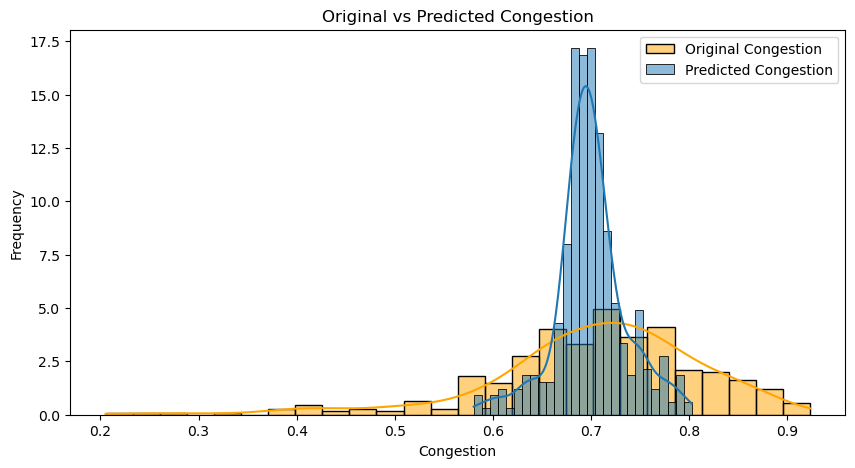

In [27]:
# plot the distribution of original congestion and predicted congestion
plt.figure(figsize=(10, 5))
sns.histplot(data.y[data.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(out[data.test_mask].cpu().detach().numpy(), kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()


In [23]:
# Visualize the results using heatmap
out.shape

torch.Size([3952, 1])

In [24]:
congestion_scaler = MinMaxScaler()
temp = congestion_scaler.fit_transform(instances[['congestion']])
temp

array([[0.69230769],
       [0.76923077],
       [0.64102564],
       ...,
       [0.84615385],
       [0.76923077],
       [0.56410256]])

In [25]:
instances_with_prediction = instances.copy()
prediction = out.cpu().detach().numpy()


unnormalization = congestion_scaler.inverse_transform(prediction)

instances_with_prediction['prediction'] = unnormalization
instances_with_prediction

,name,id,xloc,yloc,cell,orient,routing_demand,routing_capacity,congestion,prediction
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,28.0,-8.0,-6.477945
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,28.0,-5.0,-6.677543
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,33.0,-10.0,-6.255940
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,33.0,-11.0,-4.986403
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,23.0,-2.0,-5.714046
...,...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,31.0,0.0,-8.386738
3948,U4125,3948,33664,66048,42,0,30.0,30.0,0.0,-8.098202
3949,U4128,3949,23296,66048,34,0,27.0,29.0,-2.0,-8.474991
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,33.0,-5.0,-5.919574


In [26]:
# calculate the mse
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(instances_with_prediction['congestion'], instances_with_prediction['prediction'])
mse

20.891807108457456